# APS PMDI canister fluorescence : KI solutions

Post processing of X-ray canister fluorescence data with KI solutions.
Fourth step - Apply signal trapping corrections to different scans and produce usable graphs.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 14/03/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import h5py, glob, copy
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

# Get my functions from the last two notebooks, which are saved into a Python module.
from dd_xrf_functions import *
from dd_xrf_sigtrap import *

# KI Vertical scans

Mostly down the centre of the canister.

In [2]:
data={}
for propellant in ['134','152','1234']:
    
    # KI solution in ethanol
    filenames = glob.glob('%s E8 KI Canister*.h5' % propellant)
    
    for filename in filenames:
        
        # Read data
        print('Reading',filename)
        x,y,t,zP,I0,zF = readFluorescence(filename, fluorLine='I Ka', scanType='VerticalScans',\
                                          positionDecimalPlaces=(1,3))
        
        # Post process data
        pinDiode = -np.log(zP/I0)
        if propellant == '1234': prop='1234E'
        else: prop=propellant
        signalTrappingCorrection, rhoFluid = applySignalTrapping(x,y,zF,zP,I0,prop) # default E8 KI
        zF_corr = zF / signalTrappingCorrection
        
        # For vertical scans only, collapse first axis
        if x.shape[0]==1:
            x = x.reshape(*x.shape[1:])
            y = y.reshape(*y.shape[1:])
            t = t.reshape(*t.shape[1:])
            zP = zP.reshape(*zP.shape[1:])
            I0 = I0.reshape(*I0.shape[1:])
            zF = zF.reshape(*zF.shape[1:])
            zF_corr = zF_corr.reshape(*zF_corr.shape[1:])
            
             # Save data to dict
            key = '%s, x=%.2f' % (filename,np.median(x[~np.isnan(x)]))
            data[key] = {'x':x, 'y':y, 't':t, 'pinDiode':pinDiode, 'I0':I0,\
                          'fluor':zF, 'fluorCorr':zF_corr, 'rhoFluid':rhoFluid, 'propellant':propellant}
        else:
            # Split data into its various X positions if multiple were taken.
            print("  - splitting into X positions",np.unique(x))
            for i in range(x.shape[0]):
                key = '%s, x=%.2f' % (filename,np.median(x[i,~np.isnan(x[i,...])]))
                data[key] = {'x':x[i,...], 'y':y[i,...], 't':t[i,...], 'pinDiode':pinDiode[i,...], 'I0':I0[i,...],\
                          'fluor':zF[i,...], 'fluorCorr':zF_corr[i,...], 'rhoFluid':rhoFluid, 'propellant':propellant}


Reading 134 E8 KI Canister 1.h5


/Users/dduke/Desktop/2022_11_APS_PMDI/dd_xrf_functions.py:171: RuntimeWarning: invalid value encountered in divide
  cosGamma = (-rDet**2 + x**2 + z**2 + sdQ**2)/(2*sdQ*rA)


Reading 134 E8 KI Canister 2.h5
Reading 134 E8 KI Canister 13.h5
Reading 152 E8 KI Canister 9.h5
Reading 152 E8 KI Canister 3.h5
Reading 152 E8 KI Canister 10.h5
Reading 1234 E8 KI Canister 11.h5
Reading 1234 E8 KI Canister 4.h5
  - splitting into X positions [-2.1  0. ]
Reading 1234 E8 KI Canister 3.h5


<IPython.core.display.Javascript object>


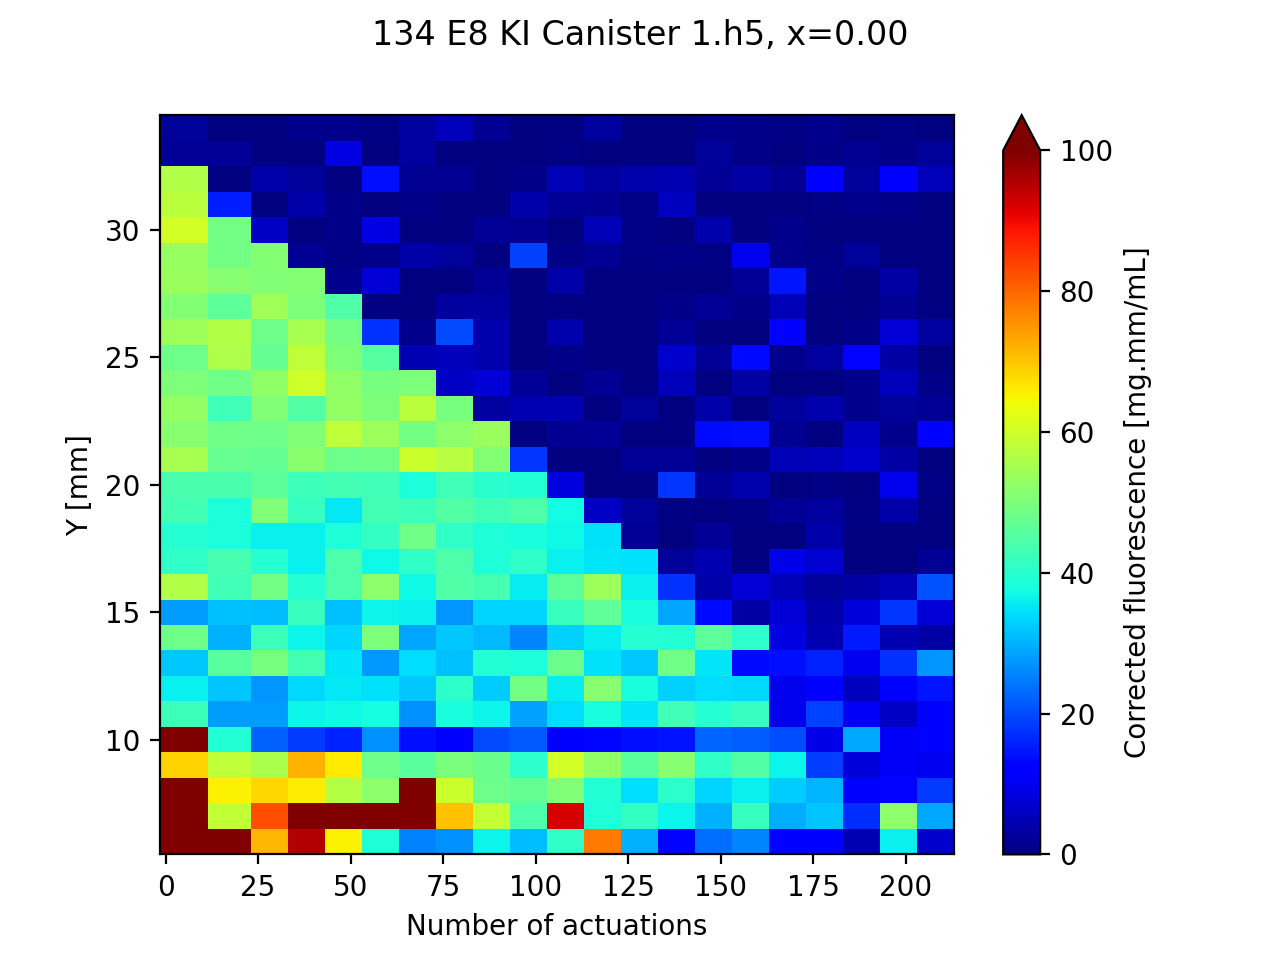

<IPython.core.display.Javascript object>


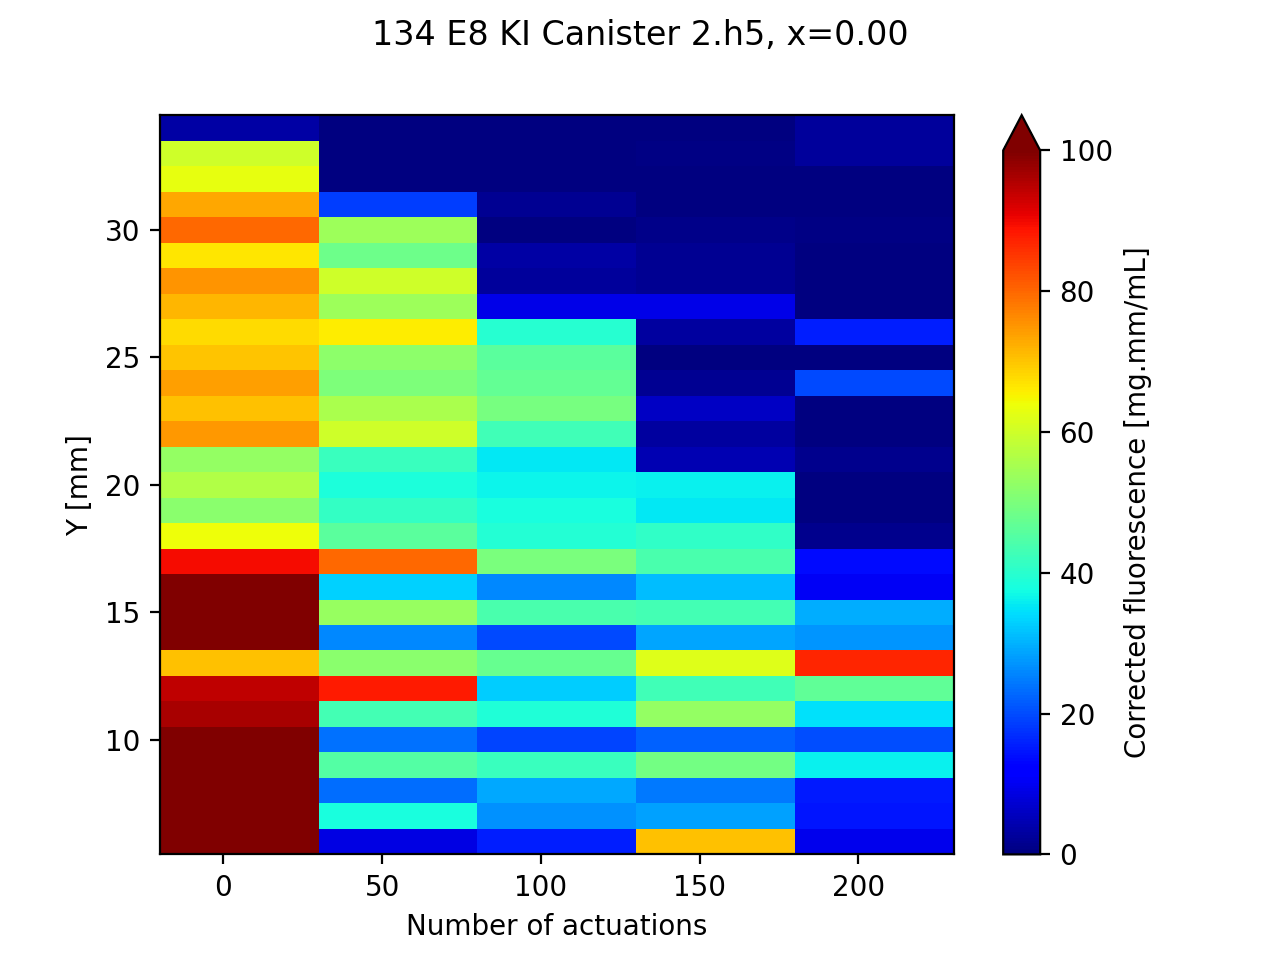

<IPython.core.display.Javascript object>


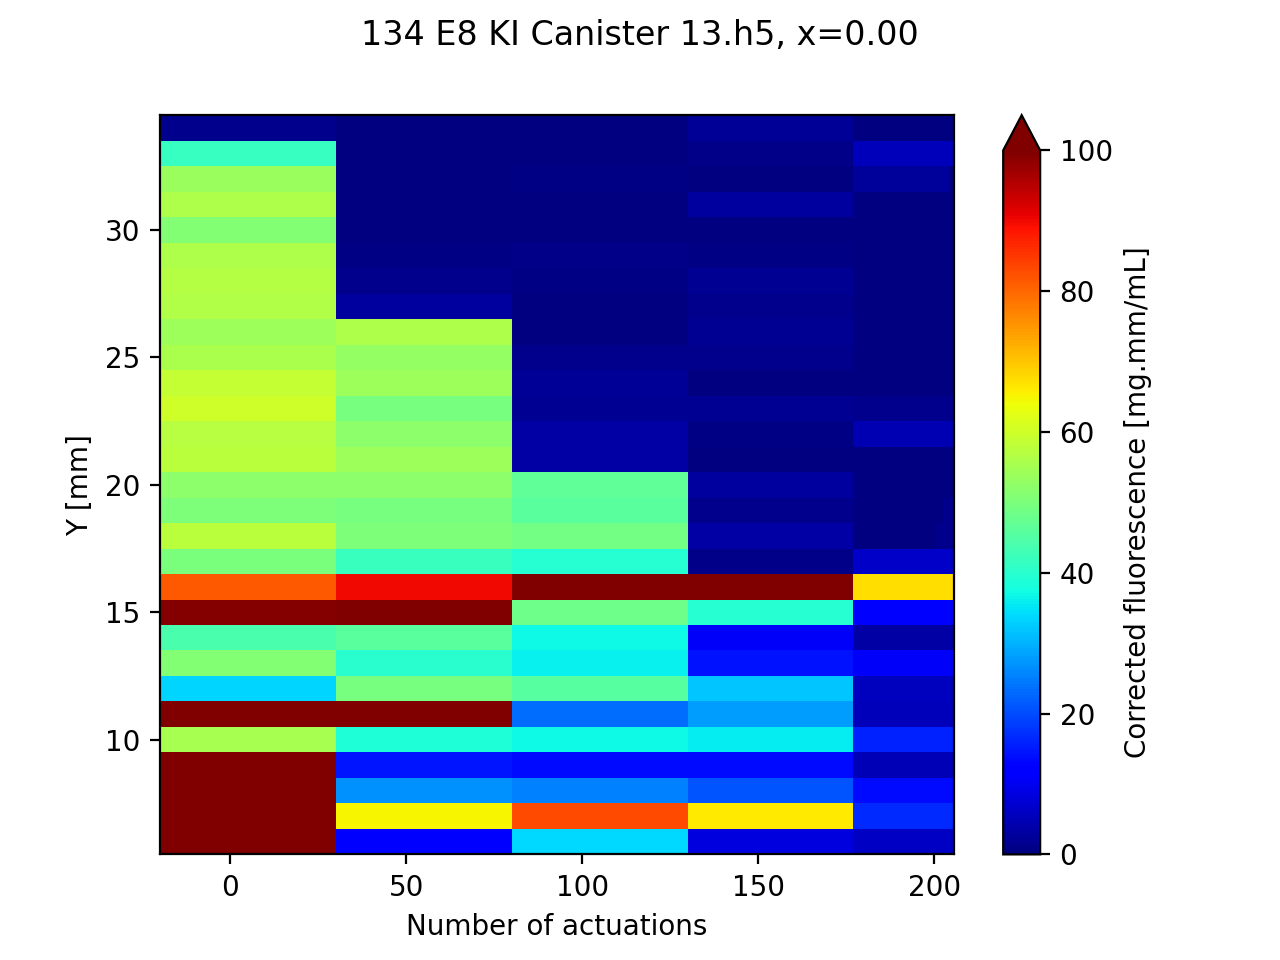

<IPython.core.display.Javascript object>


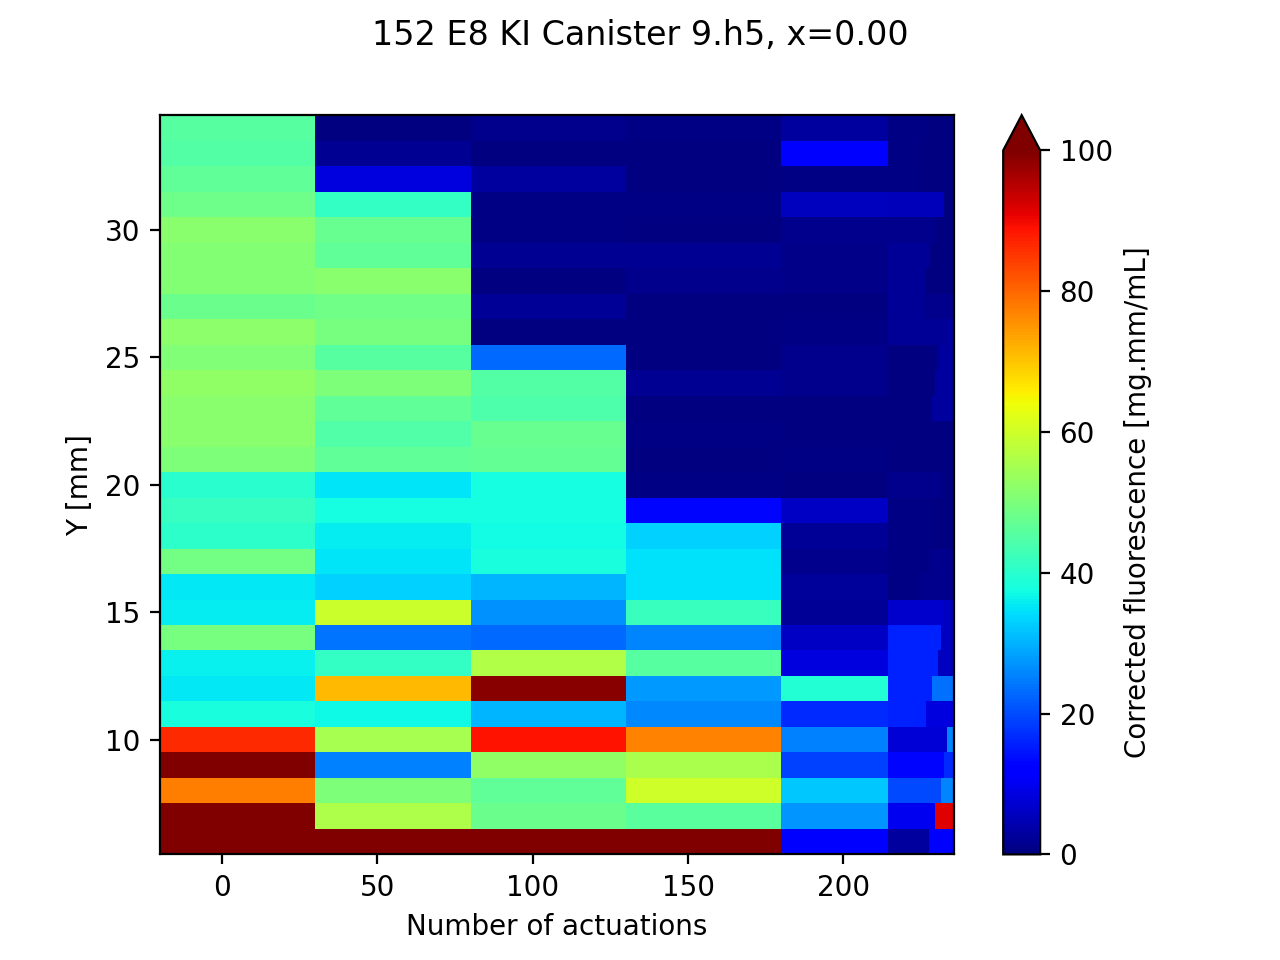

<IPython.core.display.Javascript object>


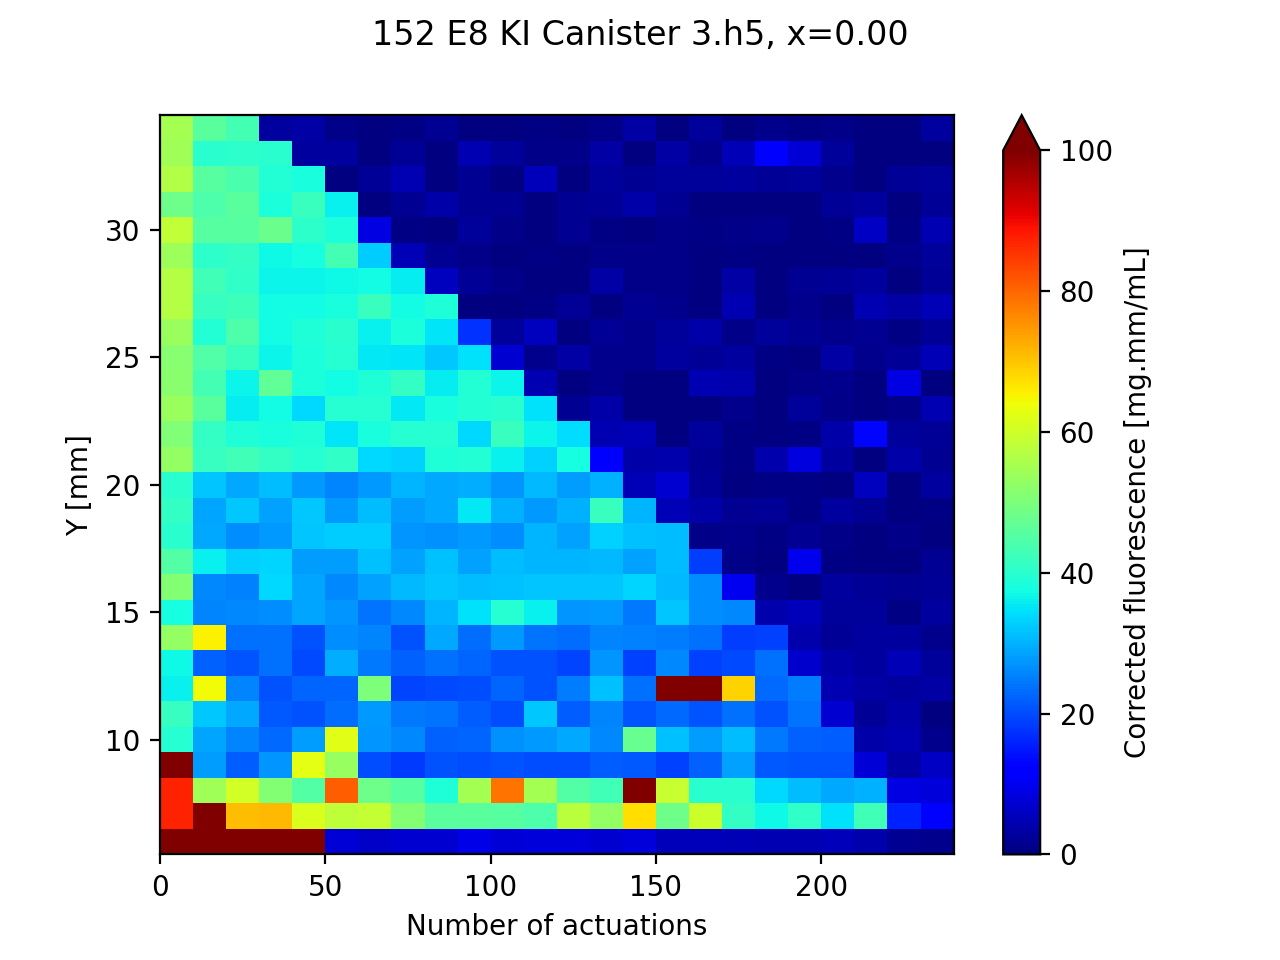

<IPython.core.display.Javascript object>


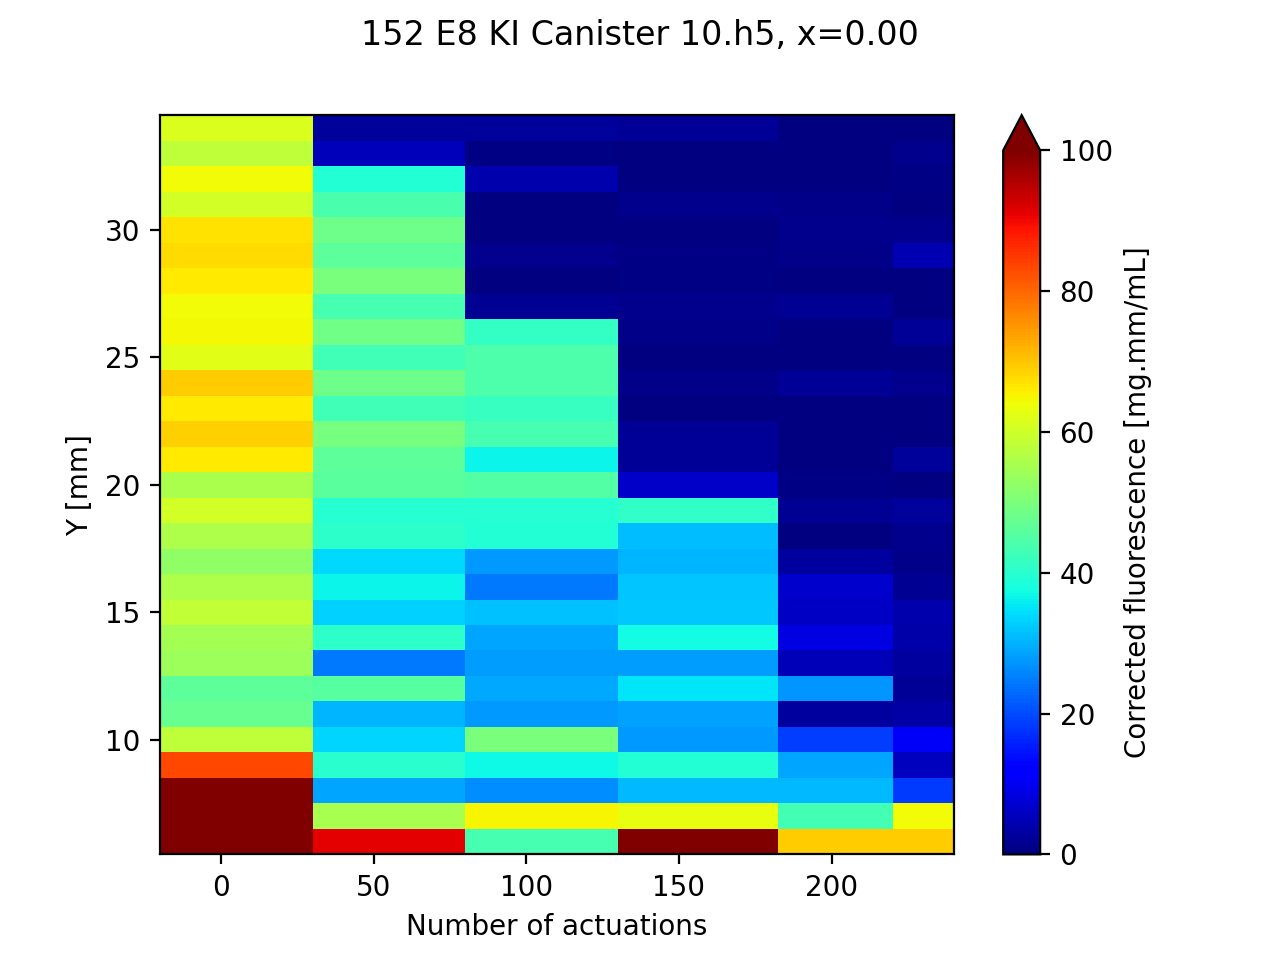

<IPython.core.display.Javascript object>


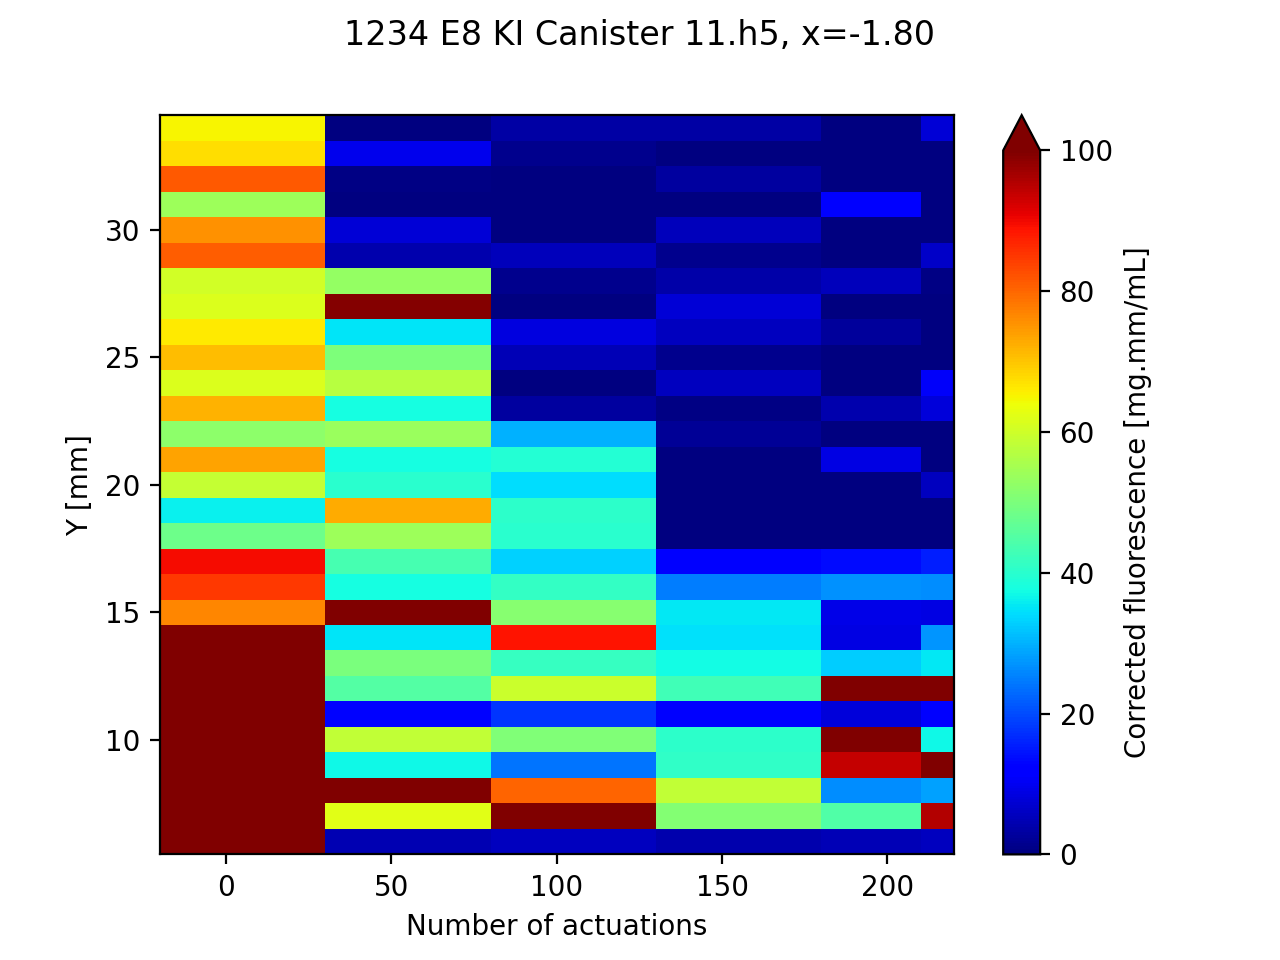

<IPython.core.display.Javascript object>


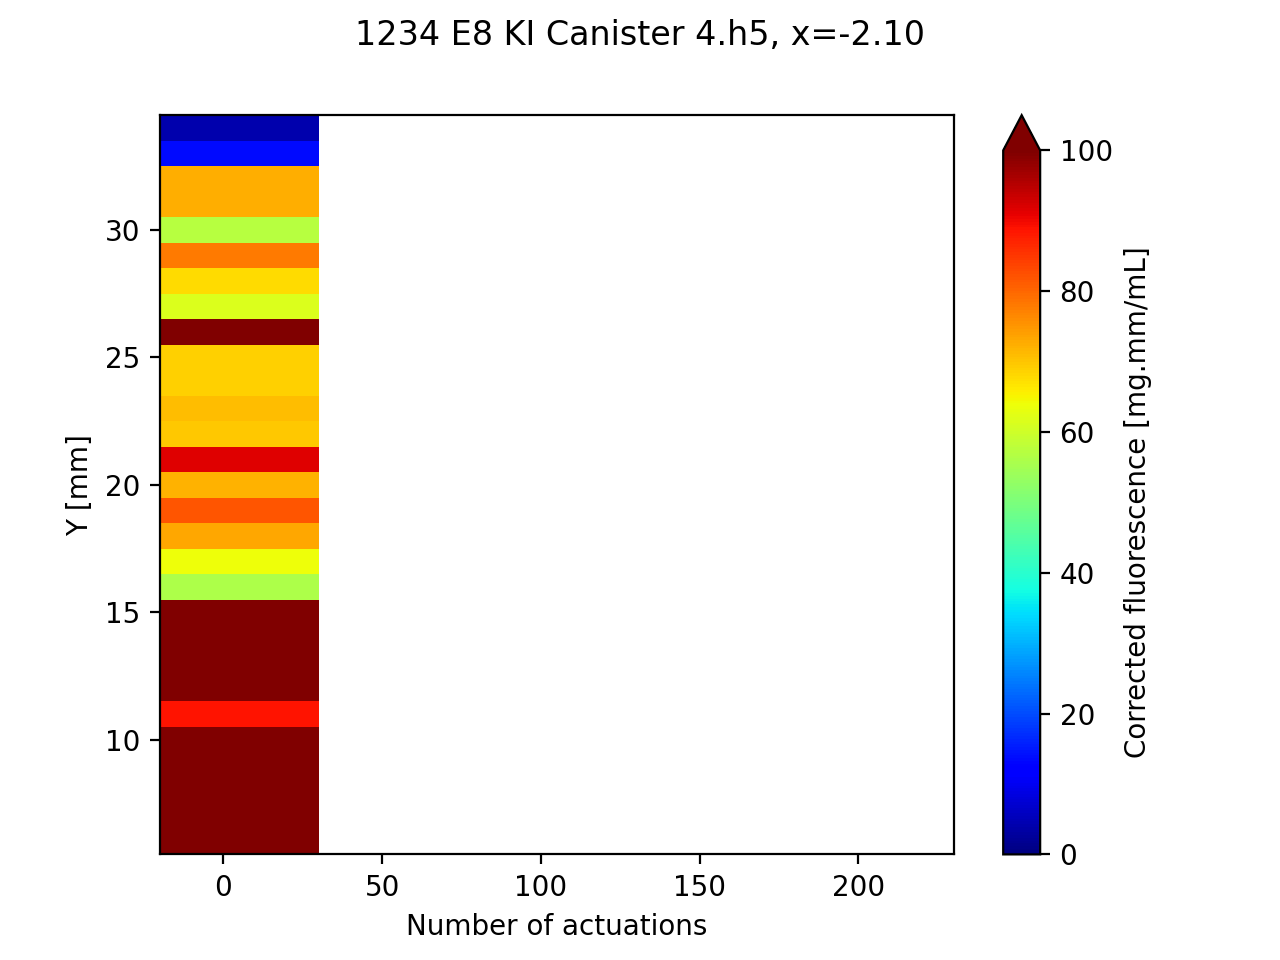

<IPython.core.display.Javascript object>


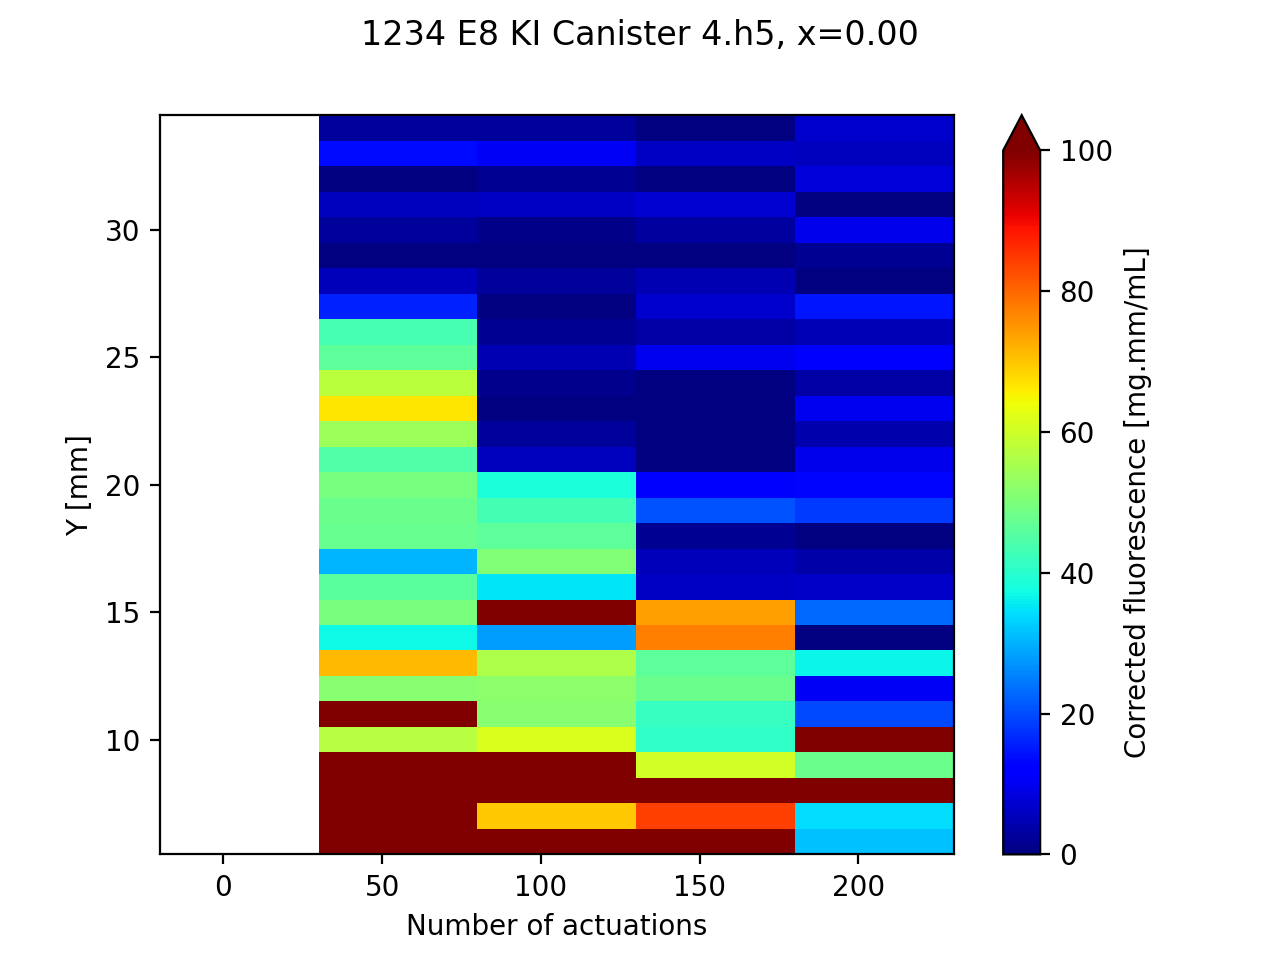

<IPython.core.display.Javascript object>


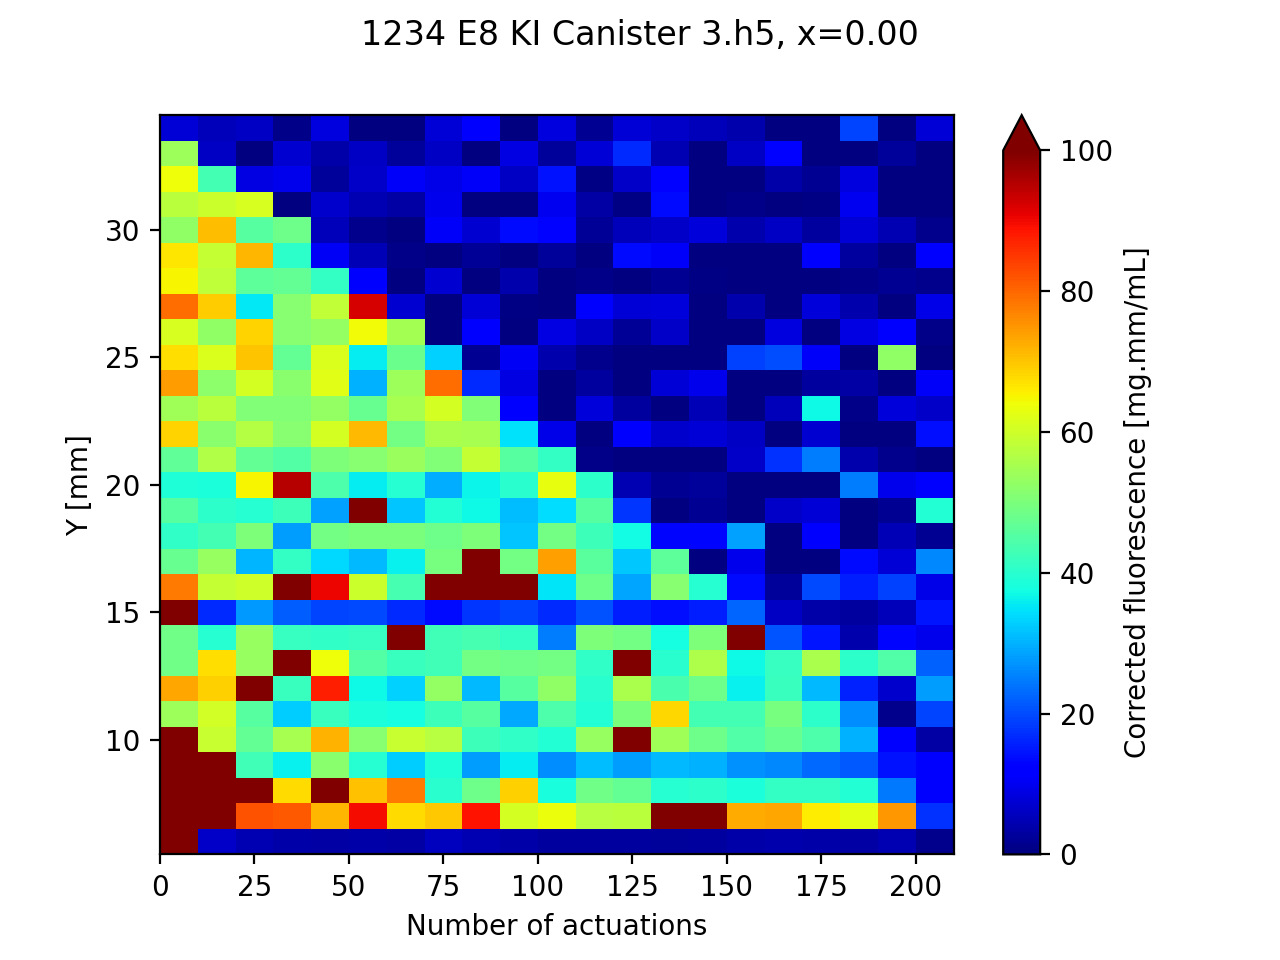

In [3]:
calibrationConstant = {'134':3.876835, '152':3.988836, '1234':1.147466}
maxVal = 100
for k in data:

    shot = data[k]['t']
    y = yTransform(data[k]['y'])
    z = copy.deepcopy(data[k]['fluorCorr']) / calibrationConstant[data[k]['propellant']]

    # Normalize data by initial level
    z_t0 = z[:,0]
    for i in range(len(z_t0)):
        if z_t0[i] > maxVal: z[i,...] /= z_t0[i]/maxVal
    
    # Filter by y position
    flt = ( y[:,0]>5 ) & ( y[:,0]< 35)
    
    fig=plt.figure()
    plt.suptitle(k)
    ax=fig.add_subplot(111)
    ph=ax.pcolormesh(shot[flt,:], y[flt,:], z[flt,:], cmap=plt.cm.jet, vmin=0, vmax=maxVal)
    plt.xlabel('Number of actuations')
    plt.ylabel('Y [mm]')
    plt.colorbar(ph,label='Corrected fluorescence [mg.mm/mL]', extend='max')
    
    
    

## Plot integrals

<IPython.core.display.Javascript object>


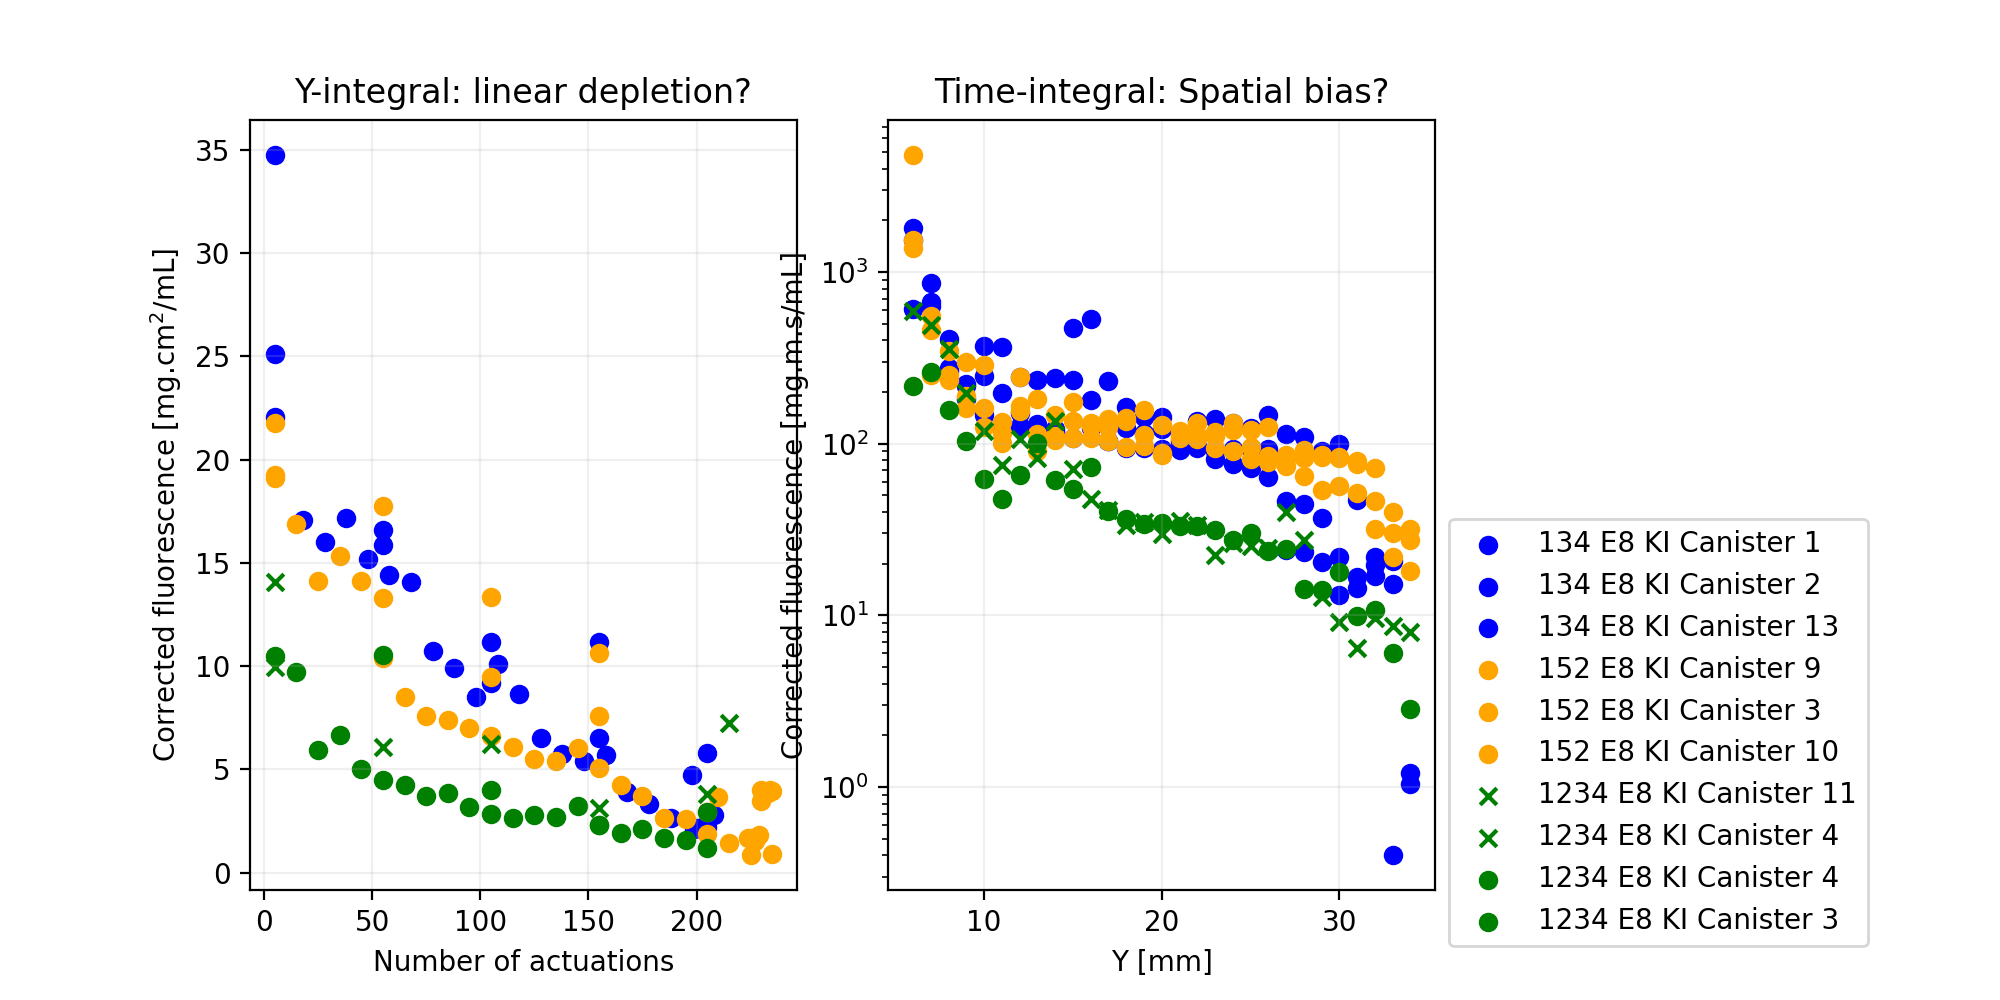

In [4]:
from matplotlib.gridspec import GridSpec

#calibrationConstant = {'134':3.876835, '152':3.988836, '1234':1.147466}
calibrationConstant = {'134':3.876835, '152':3.876835, '1234':3.876835}
deltaT=20. #s

cList={'134':'b', '152':'orange', '1234':'g'}
maxVal = 1000

fig=plt.figure(figsize=(10,5))
gs = GridSpec(1,3, width_ratios=[2,2,1])

ax1=fig.add_subplot(gs[0])
plt.grid(alpha=.2)
plt.title('Y-integral: linear depletion?')
plt.xlabel('Number of actuations')
plt.ylabel(r'Corrected fluorescence [mg.cm$^2$/mL]')

ax2=fig.add_subplot(gs[1])
ax2.set_yscale('log')
plt.grid(alpha=.2)
plt.title('Time-integral: Spatial bias?')
plt.xlabel('Y [mm]')
plt.ylabel('Corrected fluorescence [mg.m.s/mL]')


for k in data:

    xm = np.median(data[k]['x'][~np.isnan(data[k]['x'])])
    if np.abs(xm) < 9990.1: # only plot x~=0 data.       
    
        shot = data[k]['t']
        y = yTransform(data[k]['y'])
        z = copy.deepcopy(data[k]['fluorCorr']) / calibrationConstant[data[k]['propellant']]

        # Normalize data by initial level
        z_t0 = z[:,0]
        for i in range(len(z_t0)):
            if z_t0[i] > maxVal: z[i,...] /= z_t0[i]/maxVal

        # Filter by y position
        flt = ( y[:,0]>5 ) & ( y[:,0]< 35)

        # Integrate
        int1=scipy.integrate.simps(z[flt,:],axis=0,x=y[flt,0])/100. # units adjustment
        int2=scipy.integrate.simps(z[flt,:],axis=1,x=shot[0,:]*deltaT)/ 1000. # units adjustment
        
        m='o'
        if np.abs(xm) > 0.1: m='x'

        ax1.scatter(shot[0,:],-int1,label=k.split('.')[0], marker=m, c=cList[data[k]['propellant']])
        ax2.scatter(y[flt,0],int2,label=k.split('.')[0], marker=m, c=cList[data[k]['propellant']])

ax2.legend(bbox_to_anchor=(1, 0.5));

# Horizontal KI scans

# Sump scans

In [5]:
dataS={}
for propellant in ['134','152','1234']:
    
    # KI solution in ethanol
    filenames = glob.glob('%s E8 KI Canister*.h5' % propellant)
    
    for filename in filenames:
        
        # Read data
        
        x,y,t,zP,I0,zF = readFluorescence(filename, fluorLine='I Ka', scanType='SumpScans')
        
        if x is not None:
            print(filename)
            
            # Post process data
            pinDiode = -np.log(zP/I0)
            if propellant == '1234': prop='1234E'
            else: prop=propellant
            #signalTrappingCorrection, rhoFluid = applySignalTrapping(x,y,zF,zP,I0,prop)
            #zF_corr = zF / signalTrappingCorrection

             # Save data to dict
            key = '%s, x=%.2f' % (filename,np.median(x[~np.isnan(x)]))
            dataS[key] = {'x':x, 'y':y, 't':t, 'pinDiode':pinDiode, 'I0':I0,\
                          'fluor':zF, 'rhoFluid':rhoFluid, 'propellant':propellant} # 'fluorCorr':zF_corr


134 E8 KI Canister 1.h5
134 E8 KI Canister 2.h5
152 E8 KI Canister 9.h5
152 E8 KI Canister 3.h5
1234 E8 KI Canister 4.h5
1234 E8 KI Canister 3.h5


<IPython.core.display.Javascript object>


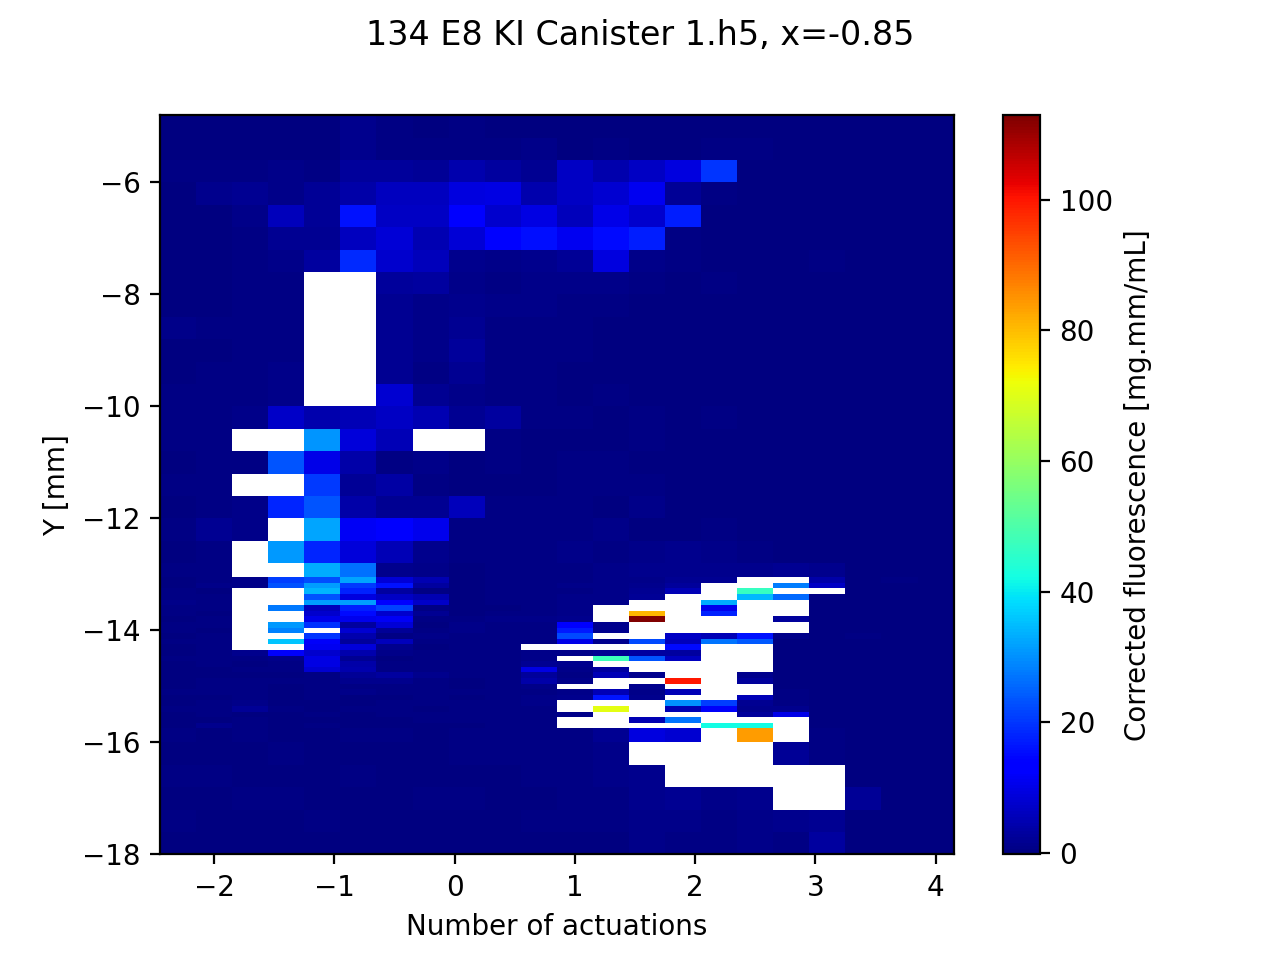

In [6]:
calibrationConstant = {'134':3.876835, '152':3.988836, '1234':1.147466}

for k in dataS:

    shot = dataS[k]['t']
    x = -dataS[k]['x']
    y = yTransform(dataS[k]['y'])
    z = copy.deepcopy(dataS[k]['fluor']) / calibrationConstant[dataS[k]['propellant']]

    # Normalize data by initial level
    #z_t0 = z[:,0]
    #for i in range(len(z_t0)):
    #    if z_t0[i] > maxVal: z[i,...] /= z_t0[i]/maxVal
    
    # Filter by y position
    flt = Ellipsis #( y[:,0]>5 ) & ( y[:,0]< 35)
    
    fig=plt.figure()
    plt.suptitle(k)
    ax=fig.add_subplot(111)
    ph=ax.pcolormesh(x[flt,:,0], y[flt,:,0], z[flt,:,0], cmap=plt.cm.jet)
    plt.xlabel('Number of actuations')
    plt.ylabel('Y [mm]')
    plt.colorbar(ph,label='Corrected fluorescence [mg.mm/mL]')
    
    break
    